In [1]:
import warnings
warnings.filterwarnings('always')
warnings.filterwarnings('ignore')

In [2]:
import os
import math
import numpy as np

from keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img
from keras.models import Sequential, Model
from keras.optimizers import Adam, SGD
from keras.utils.np_utils import to_categorical
from sklearn.metrics import accuracy_score,roc_curve, confusion_matrix, roc_auc_score, auc, f1_score
from keras.layers import Dense, Input, Dropout, Activation, Conv2D, MaxPooling2D, Lambda, Flatten, GlobalAveragePooling2D
from keras.layers.merge import concatenate

from keras.applications.vgg16 import VGG16
from keras.applications.mobilenet import MobileNet
from keras.applications.resnet50 import ResNet50

import matplotlib.pyplot as plt
%matplotlib inline

Using TensorFlow backend.


In [3]:
train_dir = 'data-ISBI-resized/train/'
validation_dir = 'data-ISBI-resized/validation/'
test_dir = 'data-ISBI-resized/test/'

extracted_features_dir = "extracted_features/"
model_name = "VGG16_Plain_SGD"

In [4]:
for root,dirs,files in os.walk(train_dir):
    print (root, len(files))

print("*"*30)
for root,dirs,files in os.walk(test_dir):
    print (root, len(files))

data-ISBI-resized/train/ 0
data-ISBI-resized/train/malignant 40425
data-ISBI-resized/train/normal 18747
******************************
data-ISBI-resized/test/ 0
data-ISBI-resized/test/malignant 655
data-ISBI-resized/test/normal 312


In [5]:
batch_size = 32
img_height, img_width = 380, 380
input_shape = (img_height, img_width, 3)
epochs = 1000

top_model_path = os.path.join(extracted_features_dir, 'model_'+model_name+'_model.h5')
top_model_weights_path = os.path.join(extracted_features_dir, 'model_'+model_name+'_weights.h5')

In [6]:
random_seed = np.random.seed(1142)

train_datagen = ImageDataGenerator(
    rescale=1. / 255,
    featurewise_center=True,
    featurewise_std_normalization=True,
#     validation_split= 0.25,
    zoom_range=0.2,
    shear_range=0.2)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    seed = random_seed,
    shuffle = False,
#     subset = 'training',
    class_mode='categorical')

validation_generator = train_datagen.flow_from_directory(
    validation_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    seed = random_seed,
    shuffle = False,
#     subset = 'validation',
    class_mode='categorical')

test_datagen = ImageDataGenerator(rescale=1. / 255)
test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    seed = random_seed,
    shuffle = False,
    class_mode='categorical')

Found 59170 images belonging to 2 classes.
Found 18384 images belonging to 2 classes.
Found 967 images belonging to 2 classes.


In [7]:
nb_train_samples = len(train_generator.filenames)
nb_validation_samples = len(validation_generator.filenames)
nb_test_samples = len(test_generator.filenames)

predict_size_train = int(math.ceil(nb_train_samples / batch_size))
predict_size_validation = int(math.ceil(nb_validation_samples / batch_size))
predict_size_test = int(math.ceil(nb_test_samples / batch_size))

num_classes = len(train_generator.class_indices)

print("nb_train_samples:", nb_train_samples)
print("nb_validation_samples:", nb_validation_samples)
print("nb_test_samples:", nb_test_samples)

print("\npredict_size_train:", predict_size_train)
print("predict_size_validation:", predict_size_validation)
print("predict_size_test:", predict_size_test)

print("\n num_classes:", num_classes)

nb_train_samples: 59170
nb_validation_samples: 18384
nb_test_samples: 967

predict_size_train: 1850
predict_size_validation: 575
predict_size_test: 31

 num_classes: 2


In [8]:
bottleneck_final_model = VGG16(include_top=False, weights='imagenet', pooling='avg')

In [9]:
bottleneck_features_train = bottleneck_final_model.predict_generator(train_generator, predict_size_train, max_q_size=1, pickle_safe=False)
np.save(extracted_features_dir+'bottleneck_features_train_'+model_name+'.npy', bottleneck_features_train)

In [10]:
bottleneck_features_validation = bottleneck_final_model.predict_generator(validation_generator, predict_size_validation)
np.save(extracted_features_dir+'bottleneck_features_validation_'+model_name+'.npy', bottleneck_features_validation)

In [11]:
bottleneck_features_test = bottleneck_final_model.predict_generator(test_generator, predict_size_test)
np.save(extracted_features_dir+'bottleneck_features_test_'+model_name+'.npy', bottleneck_features_test)

In [12]:
import tensorflow as tf
from keras.backend.tensorflow_backend import get_session
from keras.backend.tensorflow_backend import clear_session
from keras.backend.tensorflow_backend import set_session

def reset_keras_tf_session():
    """
    this function clears the gpu memory and set the 
    tf session to not use the whole gpu
    """
    sess = get_session()
    clear_session()
    sess.close()
    sess = get_session()

    config = tf.ConfigProto()
    config.gpu_options.allow_growth = True
    set_session(tf.Session(config=config))


reset_keras_tf_session()

In [13]:
train_data = np.load(extracted_features_dir+'bottleneck_features_train_'+model_name+'.npy')
validation_data = np.load(extracted_features_dir+'bottleneck_features_validation_'+model_name+'.npy')
test_data = np.load(extracted_features_dir+'bottleneck_features_test_'+model_name+'.npy')

train_labels = train_generator.classes
train_labels = to_categorical(train_labels, num_classes=num_classes)

validation_labels = validation_generator.classes
validation_labels = to_categorical(validation_labels, num_classes=num_classes)

test_labels = test_generator.classes
test_labels = to_categorical(test_labels, num_classes=num_classes)

In [14]:
model = Sequential()
# model.add(Flatten(input_shape=train_data.shape[1:]))
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.4))
model.add(Dense(num_classes, activation='softmax'))

sgd_opt=SGD(lr=0.0001, momentum=0.9, decay=0.0, nesterov=False)
# adam_opt=Adam(lr = 0.0001, beta_1=0.6, beta_2=0.999, amsgrad=True)
model.compile(optimizer=sgd_opt, loss='categorical_crossentropy', metrics=['accuracy'])

history = model.fit(train_data, train_labels,
                    epochs=epochs,
                    batch_size=batch_size,
                    validation_data=(validation_data, validation_labels),
                    verbose= 2)

with open(extracted_features_dir+'history_'+model_name+'.txt','w') as f:
    f.write(str(history.history))

model.save_weights(top_model_weights_path)
model.save(top_model_path)

Train on 59168 samples, validate on 18384 samples
Epoch 1/1000
 - 6s - loss: 0.6269 - acc: 0.6773 - val_loss: 0.6008 - val_acc: 0.6806
Epoch 2/1000
 - 5s - loss: 0.5962 - acc: 0.6844 - val_loss: 0.5843 - val_acc: 0.6806
Epoch 3/1000
 - 5s - loss: 0.5794 - acc: 0.6886 - val_loss: 0.5706 - val_acc: 0.7016
Epoch 4/1000
 - 5s - loss: 0.5651 - acc: 0.7046 - val_loss: 0.5551 - val_acc: 0.7029
Epoch 5/1000
 - 5s - loss: 0.5530 - acc: 0.7226 - val_loss: 0.5438 - val_acc: 0.7241
Epoch 6/1000
 - 5s - loss: 0.5419 - acc: 0.7411 - val_loss: 0.5335 - val_acc: 0.7468
Epoch 7/1000
 - 5s - loss: 0.5344 - acc: 0.7513 - val_loss: 0.5258 - val_acc: 0.7656
Epoch 8/1000
 - 5s - loss: 0.5273 - acc: 0.7578 - val_loss: 0.5208 - val_acc: 0.7608
Epoch 9/1000
 - 5s - loss: 0.5225 - acc: 0.7643 - val_loss: 0.5175 - val_acc: 0.7620
Epoch 10/1000
 - 5s - loss: 0.5186 - acc: 0.7664 - val_loss: 0.5131 - val_acc: 0.7681
Epoch 11/1000
 - 5s - loss: 0.5154 - acc: 0.7686 - val_loss: 0.5086 - val_acc: 0.7738
Epoch 12/1000

Epoch 96/1000
 - 5s - loss: 0.4835 - acc: 0.7835 - val_loss: 0.4831 - val_acc: 0.7828
Epoch 97/1000
 - 5s - loss: 0.4828 - acc: 0.7841 - val_loss: 0.4821 - val_acc: 0.7854
Epoch 98/1000
 - 5s - loss: 0.4828 - acc: 0.7834 - val_loss: 0.4818 - val_acc: 0.7854
Epoch 99/1000
 - 5s - loss: 0.4824 - acc: 0.7837 - val_loss: 0.4813 - val_acc: 0.7856
Epoch 100/1000
 - 5s - loss: 0.4827 - acc: 0.7829 - val_loss: 0.4809 - val_acc: 0.7859
Epoch 101/1000
 - 5s - loss: 0.4820 - acc: 0.7839 - val_loss: 0.4816 - val_acc: 0.7854
Epoch 102/1000
 - 5s - loss: 0.4820 - acc: 0.7830 - val_loss: 0.4801 - val_acc: 0.7863
Epoch 103/1000
 - 5s - loss: 0.4819 - acc: 0.7846 - val_loss: 0.4802 - val_acc: 0.7863
Epoch 104/1000
 - 5s - loss: 0.4816 - acc: 0.7846 - val_loss: 0.4821 - val_acc: 0.7843
Epoch 105/1000
 - 5s - loss: 0.4817 - acc: 0.7846 - val_loss: 0.4800 - val_acc: 0.7862
Epoch 106/1000
 - 5s - loss: 0.4813 - acc: 0.7844 - val_loss: 0.4804 - val_acc: 0.7855
Epoch 107/1000
 - 5s - loss: 0.4813 - acc: 0.78

Epoch 191/1000
 - 5s - loss: 0.4684 - acc: 0.7905 - val_loss: 0.4682 - val_acc: 0.7928
Epoch 192/1000
 - 5s - loss: 0.4674 - acc: 0.7907 - val_loss: 0.4679 - val_acc: 0.7925
Epoch 193/1000
 - 5s - loss: 0.4683 - acc: 0.7905 - val_loss: 0.4678 - val_acc: 0.7934
Epoch 194/1000
 - 5s - loss: 0.4682 - acc: 0.7904 - val_loss: 0.4689 - val_acc: 0.7928
Epoch 195/1000
 - 5s - loss: 0.4677 - acc: 0.7904 - val_loss: 0.4720 - val_acc: 0.7888
Epoch 196/1000
 - 5s - loss: 0.4676 - acc: 0.7910 - val_loss: 0.4676 - val_acc: 0.7936
Epoch 197/1000
 - 5s - loss: 0.4670 - acc: 0.7911 - val_loss: 0.4726 - val_acc: 0.7911
Epoch 198/1000
 - 5s - loss: 0.4673 - acc: 0.7909 - val_loss: 0.4692 - val_acc: 0.7937
Epoch 199/1000
 - 5s - loss: 0.4673 - acc: 0.7908 - val_loss: 0.4669 - val_acc: 0.7940
Epoch 200/1000
 - 5s - loss: 0.4679 - acc: 0.7900 - val_loss: 0.4714 - val_acc: 0.7913
Epoch 201/1000
 - 5s - loss: 0.4672 - acc: 0.7896 - val_loss: 0.4672 - val_acc: 0.7938
Epoch 202/1000
 - 5s - loss: 0.4671 - acc: 

 - 5s - loss: 0.4573 - acc: 0.7953 - val_loss: 0.4699 - val_acc: 0.7927
Epoch 286/1000
 - 5s - loss: 0.4578 - acc: 0.7964 - val_loss: 0.4601 - val_acc: 0.7971
Epoch 287/1000
 - 5s - loss: 0.4576 - acc: 0.7962 - val_loss: 0.4603 - val_acc: 0.7976
Epoch 288/1000
 - 5s - loss: 0.4577 - acc: 0.7949 - val_loss: 0.4613 - val_acc: 0.7967
Epoch 289/1000
 - 5s - loss: 0.4582 - acc: 0.7952 - val_loss: 0.4584 - val_acc: 0.7982
Epoch 290/1000
 - 5s - loss: 0.4585 - acc: 0.7948 - val_loss: 0.4596 - val_acc: 0.7972
Epoch 291/1000
 - 5s - loss: 0.4564 - acc: 0.7961 - val_loss: 0.4588 - val_acc: 0.7990
Epoch 292/1000
 - 5s - loss: 0.4572 - acc: 0.7969 - val_loss: 0.4582 - val_acc: 0.7987
Epoch 293/1000
 - 5s - loss: 0.4571 - acc: 0.7967 - val_loss: 0.4584 - val_acc: 0.7988
Epoch 294/1000
 - 5s - loss: 0.4576 - acc: 0.7946 - val_loss: 0.4584 - val_acc: 0.7978
Epoch 295/1000
 - 5s - loss: 0.4571 - acc: 0.7964 - val_loss: 0.4593 - val_acc: 0.7981
Epoch 296/1000
 - 5s - loss: 0.4567 - acc: 0.7972 - val_lo

Epoch 380/1000
 - 5s - loss: 0.4502 - acc: 0.8005 - val_loss: 0.4560 - val_acc: 0.7999
Epoch 381/1000
 - 5s - loss: 0.4502 - acc: 0.8003 - val_loss: 0.4528 - val_acc: 0.8006
Epoch 382/1000
 - 5s - loss: 0.4497 - acc: 0.8009 - val_loss: 0.4524 - val_acc: 0.8010
Epoch 383/1000
 - 5s - loss: 0.4505 - acc: 0.8006 - val_loss: 0.4560 - val_acc: 0.7985
Epoch 384/1000
 - 5s - loss: 0.4508 - acc: 0.7998 - val_loss: 0.4542 - val_acc: 0.7992
Epoch 385/1000
 - 5s - loss: 0.4499 - acc: 0.8003 - val_loss: 0.4535 - val_acc: 0.8005
Epoch 386/1000
 - 5s - loss: 0.4505 - acc: 0.8008 - val_loss: 0.4524 - val_acc: 0.8016
Epoch 387/1000
 - 5s - loss: 0.4500 - acc: 0.7995 - val_loss: 0.4518 - val_acc: 0.8004
Epoch 388/1000
 - 5s - loss: 0.4506 - acc: 0.7996 - val_loss: 0.4542 - val_acc: 0.7990
Epoch 389/1000
 - 5s - loss: 0.4501 - acc: 0.8005 - val_loss: 0.4551 - val_acc: 0.8005
Epoch 390/1000
 - 5s - loss: 0.4501 - acc: 0.8005 - val_loss: 0.4590 - val_acc: 0.7992
Epoch 391/1000
 - 5s - loss: 0.4498 - acc: 

 - 5s - loss: 0.4453 - acc: 0.8020 - val_loss: 0.4615 - val_acc: 0.7956
Epoch 475/1000
 - 5s - loss: 0.4451 - acc: 0.8037 - val_loss: 0.4515 - val_acc: 0.8019
Epoch 476/1000
 - 5s - loss: 0.4451 - acc: 0.8029 - val_loss: 0.4479 - val_acc: 0.8031
Epoch 477/1000
 - 5s - loss: 0.4455 - acc: 0.8032 - val_loss: 0.4480 - val_acc: 0.8040
Epoch 478/1000
 - 5s - loss: 0.4454 - acc: 0.8037 - val_loss: 0.4485 - val_acc: 0.8043
Epoch 479/1000
 - 5s - loss: 0.4437 - acc: 0.8037 - val_loss: 0.4498 - val_acc: 0.8042
Epoch 480/1000
 - 5s - loss: 0.4461 - acc: 0.8028 - val_loss: 0.4493 - val_acc: 0.8027
Epoch 481/1000
 - 5s - loss: 0.4451 - acc: 0.8030 - val_loss: 0.4475 - val_acc: 0.8035
Epoch 482/1000
 - 5s - loss: 0.4446 - acc: 0.8025 - val_loss: 0.4477 - val_acc: 0.8031
Epoch 483/1000
 - 5s - loss: 0.4446 - acc: 0.8031 - val_loss: 0.4486 - val_acc: 0.8058
Epoch 484/1000
 - 5s - loss: 0.4448 - acc: 0.8024 - val_loss: 0.4488 - val_acc: 0.8040
Epoch 485/1000
 - 5s - loss: 0.4440 - acc: 0.8037 - val_lo

Epoch 569/1000
 - 5s - loss: 0.4404 - acc: 0.8059 - val_loss: 0.4465 - val_acc: 0.8065
Epoch 570/1000
 - 5s - loss: 0.4406 - acc: 0.8056 - val_loss: 0.4438 - val_acc: 0.8065
Epoch 571/1000
 - 5s - loss: 0.4395 - acc: 0.8077 - val_loss: 0.4523 - val_acc: 0.8057
Epoch 572/1000
 - 5s - loss: 0.4406 - acc: 0.8048 - val_loss: 0.4504 - val_acc: 0.8044
Epoch 573/1000
 - 5s - loss: 0.4412 - acc: 0.8051 - val_loss: 0.4438 - val_acc: 0.8062
Epoch 574/1000
 - 5s - loss: 0.4406 - acc: 0.8052 - val_loss: 0.4446 - val_acc: 0.8048
Epoch 575/1000
 - 5s - loss: 0.4408 - acc: 0.8047 - val_loss: 0.4517 - val_acc: 0.8037
Epoch 576/1000
 - 5s - loss: 0.4403 - acc: 0.8052 - val_loss: 0.4434 - val_acc: 0.8061
Epoch 577/1000
 - 5s - loss: 0.4391 - acc: 0.8071 - val_loss: 0.4450 - val_acc: 0.8068
Epoch 578/1000
 - 5s - loss: 0.4414 - acc: 0.8059 - val_loss: 0.4437 - val_acc: 0.8062
Epoch 579/1000
 - 5s - loss: 0.4399 - acc: 0.8061 - val_loss: 0.4439 - val_acc: 0.8059
Epoch 580/1000
 - 5s - loss: 0.4410 - acc: 

 - 5s - loss: 0.4364 - acc: 0.8081 - val_loss: 0.4407 - val_acc: 0.8079
Epoch 664/1000
 - 5s - loss: 0.4366 - acc: 0.8084 - val_loss: 0.4402 - val_acc: 0.8089
Epoch 665/1000
 - 5s - loss: 0.4360 - acc: 0.8073 - val_loss: 0.4425 - val_acc: 0.8072
Epoch 666/1000
 - 5s - loss: 0.4364 - acc: 0.8085 - val_loss: 0.4423 - val_acc: 0.8083
Epoch 667/1000
 - 5s - loss: 0.4369 - acc: 0.8077 - val_loss: 0.4421 - val_acc: 0.8071
Epoch 668/1000
 - 5s - loss: 0.4371 - acc: 0.8071 - val_loss: 0.4416 - val_acc: 0.8078
Epoch 669/1000
 - 5s - loss: 0.4364 - acc: 0.8066 - val_loss: 0.4427 - val_acc: 0.8095
Epoch 670/1000
 - 5s - loss: 0.4354 - acc: 0.8080 - val_loss: 0.4407 - val_acc: 0.8095
Epoch 671/1000
 - 5s - loss: 0.4370 - acc: 0.8070 - val_loss: 0.4471 - val_acc: 0.8048
Epoch 672/1000
 - 5s - loss: 0.4361 - acc: 0.8082 - val_loss: 0.4409 - val_acc: 0.8072
Epoch 673/1000
 - 5s - loss: 0.4368 - acc: 0.8080 - val_loss: 0.4411 - val_acc: 0.8086
Epoch 674/1000
 - 5s - loss: 0.4357 - acc: 0.8094 - val_lo

Epoch 758/1000
 - 5s - loss: 0.4331 - acc: 0.8095 - val_loss: 0.4400 - val_acc: 0.8121
Epoch 759/1000
 - 5s - loss: 0.4330 - acc: 0.8091 - val_loss: 0.4427 - val_acc: 0.8071
Epoch 760/1000
 - 5s - loss: 0.4329 - acc: 0.8096 - val_loss: 0.4384 - val_acc: 0.8109
Epoch 761/1000
 - 5s - loss: 0.4332 - acc: 0.8088 - val_loss: 0.4432 - val_acc: 0.8096
Epoch 762/1000
 - 5s - loss: 0.4342 - acc: 0.8097 - val_loss: 0.4383 - val_acc: 0.8108
Epoch 763/1000
 - 5s - loss: 0.4325 - acc: 0.8107 - val_loss: 0.4390 - val_acc: 0.8120
Epoch 764/1000
 - 5s - loss: 0.4325 - acc: 0.8099 - val_loss: 0.4382 - val_acc: 0.8101
Epoch 765/1000
 - 5s - loss: 0.4346 - acc: 0.8089 - val_loss: 0.4402 - val_acc: 0.8112
Epoch 766/1000
 - 5s - loss: 0.4323 - acc: 0.8100 - val_loss: 0.4389 - val_acc: 0.8107
Epoch 767/1000
 - 5s - loss: 0.4329 - acc: 0.8101 - val_loss: 0.4395 - val_acc: 0.8094
Epoch 768/1000
 - 5s - loss: 0.4335 - acc: 0.8098 - val_loss: 0.4372 - val_acc: 0.8114
Epoch 769/1000
 - 5s - loss: 0.4329 - acc: 

 - 5s - loss: 0.4318 - acc: 0.8107 - val_loss: 0.4475 - val_acc: 0.8079
Epoch 853/1000
 - 5s - loss: 0.4311 - acc: 0.8118 - val_loss: 0.4348 - val_acc: 0.8136
Epoch 854/1000
 - 5s - loss: 0.4300 - acc: 0.8112 - val_loss: 0.4348 - val_acc: 0.8123
Epoch 855/1000
 - 5s - loss: 0.4301 - acc: 0.8119 - val_loss: 0.4359 - val_acc: 0.8140
Epoch 856/1000
 - 5s - loss: 0.4309 - acc: 0.8111 - val_loss: 0.4410 - val_acc: 0.8087
Epoch 857/1000
 - 5s - loss: 0.4305 - acc: 0.8118 - val_loss: 0.4436 - val_acc: 0.8126
Epoch 858/1000
 - 5s - loss: 0.4309 - acc: 0.8111 - val_loss: 0.4379 - val_acc: 0.8105
Epoch 859/1000
 - 5s - loss: 0.4301 - acc: 0.8117 - val_loss: 0.4375 - val_acc: 0.8105
Epoch 860/1000
 - 5s - loss: 0.4304 - acc: 0.8105 - val_loss: 0.4497 - val_acc: 0.8019
Epoch 861/1000
 - 5s - loss: 0.4310 - acc: 0.8113 - val_loss: 0.4438 - val_acc: 0.8096
Epoch 862/1000
 - 5s - loss: 0.4301 - acc: 0.8112 - val_loss: 0.4365 - val_acc: 0.8130
Epoch 863/1000
 - 5s - loss: 0.4305 - acc: 0.8115 - val_lo

Epoch 947/1000
 - 5s - loss: 0.4270 - acc: 0.8132 - val_loss: 0.4340 - val_acc: 0.8135
Epoch 948/1000
 - 5s - loss: 0.4279 - acc: 0.8111 - val_loss: 0.4342 - val_acc: 0.8150
Epoch 949/1000
 - 5s - loss: 0.4289 - acc: 0.8111 - val_loss: 0.4497 - val_acc: 0.8109
Epoch 950/1000
 - 5s - loss: 0.4280 - acc: 0.8131 - val_loss: 0.4325 - val_acc: 0.8146
Epoch 951/1000
 - 5s - loss: 0.4285 - acc: 0.8120 - val_loss: 0.4352 - val_acc: 0.8148
Epoch 952/1000
 - 5s - loss: 0.4280 - acc: 0.8130 - val_loss: 0.4476 - val_acc: 0.8047
Epoch 953/1000
 - 5s - loss: 0.4268 - acc: 0.8139 - val_loss: 0.4331 - val_acc: 0.8145
Epoch 954/1000
 - 5s - loss: 0.4279 - acc: 0.8131 - val_loss: 0.4339 - val_acc: 0.8134
Epoch 955/1000
 - 5s - loss: 0.4285 - acc: 0.8113 - val_loss: 0.4334 - val_acc: 0.8158
Epoch 956/1000
 - 5s - loss: 0.4281 - acc: 0.8131 - val_loss: 0.4332 - val_acc: 0.8123
Epoch 957/1000
 - 5s - loss: 0.4272 - acc: 0.8120 - val_loss: 0.4358 - val_acc: 0.8122
Epoch 958/1000
 - 5s - loss: 0.4275 - acc: 

In [15]:
(eval_loss, eval_accuracy) = model.evaluate(validation_data, validation_labels, batch_size= batch_size, verbose=1)

print("Validation Accuracy: {:.4f}%".format(eval_accuracy * 100))
print("Validation Loss: {}".format(eval_loss))

18384/18384 [==============================] - 1s 32us/step
Validation Accuracy: 81.3098%
Validation Loss: 0.4371305633566502


In [16]:
preds = model.predict(test_data)

predictions = [i.argmax() for i in preds]
y_true = [i.argmax() for i in test_labels]
cm = confusion_matrix(y_pred=predictions, y_true=y_true)

print('Accuracy {}'.format(accuracy_score(y_true=y_true, y_pred=predictions)))

Accuracy 0.8076525336091003


Confusion Matrix
[[650   5]
 [181 131]]


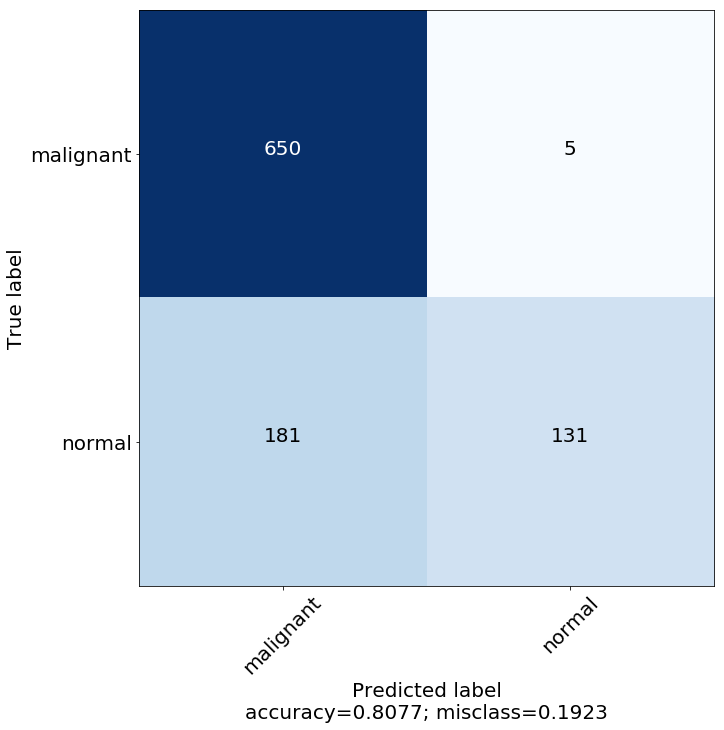

In [17]:
plt.rcParams["axes.grid"] = False
plt.rcParams.update({'font.size': 20})

labels = []

label = test_generator.class_indices
indexlabel = dict((value, key) for key, value in label.items())

for k,v in indexlabel.items():
    labels.append(v)

from sklearn.metrics import confusion_matrix
import itertools
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion Matrix')

    print(cm)
#     fig = plt.figure()
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
#     plt.title(title)
#     plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
#     plt.savefig('plots/3.InceptionV3-2-Private-DataSet-CM.png', bbox_inches='tight', dpi = 100) 


plt.figure(figsize=(10,10))
plot_confusion_matrix(cm, classes=labels, title=' ')

In [18]:
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, classification_report
y_pred=predictions
y_pred_probabilities=y_pred

# y_pred = np.argmax(y_pred,axis = 1) 
y_actual = y_true

classnames=[]
for classname in test_generator.class_indices:
    classnames.append(classname)

confusion_mtx = confusion_matrix(y_actual, y_pred) 
print(confusion_mtx)
target_names = classnames
print(classification_report(y_actual, y_pred, target_names=target_names))

[[650   5]
 [181 131]]
              precision    recall  f1-score   support

   malignant       0.78      0.99      0.87       655
      normal       0.96      0.42      0.58       312

   micro avg       0.81      0.81      0.81       967
   macro avg       0.87      0.71      0.73       967
weighted avg       0.84      0.81      0.78       967



In [19]:
total=sum(sum(cm))

# accuracy = (cm[0,0]+cm[1,1]) / total
# print ('Accuracy : ', accuracy*100)

sensitivity = cm[0,0]/(cm[0,0]+cm[1,0])
print('Sensitivity : ', sensitivity*100 )

Specificity = cm[1,1]/(cm[1,1]+cm[0,1])
print('Specificity : ', Specificity*100 )

Sensitivity :  78.21901323706378
Specificity :  96.32352941176471


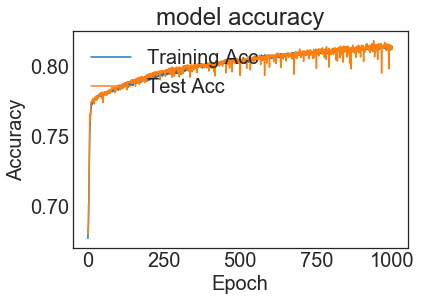

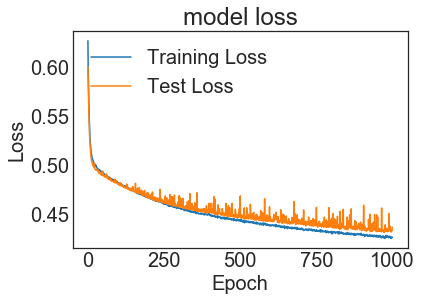

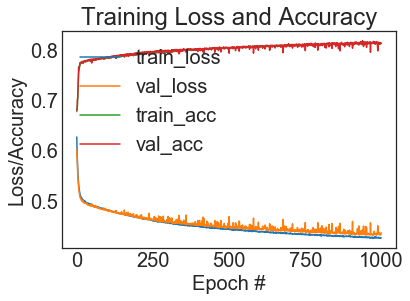

In [20]:
import seaborn
plt.style.use('seaborn-white')

plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Training Acc', 'Test Acc'], loc='upper left')
plt.show()

# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training Loss', 'Test Loss'], loc='upper left')
plt.show()

plt.figure()
N = epochs
plt.plot(np.arange(0, N), history.history["loss"], label="train_loss")
plt.plot(np.arange(0, N), history.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, N), history.history["acc"], label="train_acc")
plt.plot(np.arange(0, N), history.history["val_acc"], label="val_acc")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="upper left")

In [21]:
y_pred_class = model.predict(test_data, verbose=1)

y_pred_class = [np.argmax(r) for r in y_pred_class]
test_y = [np.argmax(r) for r in test_labels]


from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score, cohen_kappa_score, roc_auc_score, roc_curve

# Precision
print('Precision = ', precision_score(test_y, y_pred_class, average='weighted'))
# (None, 'micro', 'macro', 'weighted', 'samples')

# Recall
print('Recall = ', recall_score(test_y, y_pred_class, average='weighted'))

# f1_score
print('f1_score = ', f1_score(test_y, y_pred_class, average='weighted'))

967/967 [==============================] - 0s 41us/step
Precision =  0.840603876388287
Recall =  0.8076525336091003
f1_score =  0.7812606934431311


In [22]:
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import LabelBinarizer

def multiclass_roc_auc_score(y_test, y_pred, average="weighted"):
    label_binarizer = LabelBinarizer()
    label_binarizer.fit(y_test)

    truth = label_binarizer.transform(y_test)
    pred = label_binarizer.transform(y_pred)
    return roc_auc_score(truth, pred, average=average)
# roc_auc_score
print('roc_auc_score = ', multiclass_roc_auc_score(test_y, y_pred_class))

roc_auc_score =  0.7061191035427676


In [23]:
sample_count = test_generator.samples
print('Sample count: {}'.format(sample_count))

fnames = test_generator.filenames
ground_truth = test_generator.classes
label2index = test_generator.class_indices
# Getting the mapping from class index to class label
idx2label = dict((v, k) for k, v in label2index.items())
predictions = model.predict_classes(test_data)
prob = model.predict(test_data)
errors = np.where(predictions != ground_truth)[0]
print("No of errors = {}/{}".format(len(errors), sample_count))

Sample count: 967
No of errors = 186/967
